In [ ]:
import sys
sys.path.append('..')

In [1]:
from parser import public_construct, public_match, public_match_exact

In [2]:
import tls13

In [3]:
try:
    https_conn.close()
except:
    pass

https_conn = tls13.connect('www.google.com', 443, 'h2')

In [4]:
headers = [
    (':authority', 'www.google.com'),
    (':method', 'GET'),
    (':path', '/'),
    (':scheme', 'https'),
]

In [5]:
import hpack
hpac_enc = hpack.Encoder()
headers_encoded = hpac_enc.encode(headers)
headers_encoded

b'A\x8b\xf1\xe3\xc2\xf3\x1c\xf3PU\xc8z\x7f\x82\x84\x87'

In [6]:
http2_frame_spec = """
24+6(
    8==4?8@flags-4B@streamid-...@settings(
        16@parameter-32@value        
    )
    :8==8?8@flags-4B@streamid-4B@window_size
    :8==1?8@flags-4B@streamid-@headers
    :8==0?8@flags-4B@streamid-@data
    :8@selector-8@flags-4B@streamid-@data
)
"""

In [7]:
http2_header = b"PRI * HTTP/2.0\r\n\r\nSM\r\n\r\n"
settings_frame = {
    'flags': 0x00,
    '_selector': 0x04,
    'streamid': 0x00000000,
    'settings': [
        {'parameter': 0x0002, 'value': 0x00000000},
        {'parameter': 0x0004, 'value': 0x00400000},
        {'parameter': 0x0006, 'value': 0x00a00000}
    ]
}
window_size_update_frame = {
    'flags': 0x00,
    '_selector': 0x08,
    'streamid': 0x00000000,
    'window_size': 0x40000000
}
headers_frame = {
    'flags': 0x05,
    '_selector': 0x01,
    'streamid': 0x00000001,
    'headers': headers_encoded
}
final_settings_frame = {
    'flags': 0x01,
    '_selector': 0x04,
    'streamid': 0x00000000,
    'settings': []
}

In [8]:
http2_req_encoded = \
    http2_header + \
    public_construct(http2_frame_spec, settings_frame) + \
    public_construct(http2_frame_spec, window_size_update_frame) + \
    public_construct(http2_frame_spec, headers_frame) + \
    public_construct(http2_frame_spec, final_settings_frame)

http2_req_encoded

b'PRI * HTTP/2.0\r\n\r\nSM\r\n\r\n\x00\x00\x12\x04\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x04\x00@\x00\x00\x00\x06\x00\xa0\x00\x00\x00\x00\x04\x08\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x10\x01\x05\x00\x00\x00\x01A\x8b\xf1\xe3\xc2\xf3\x1c\xf3PU\xc8z\x7f\x82\x84\x87\x00\x00\x00\x04\x01\x00\x00\x00\x00'

In [9]:
https_conn.send(http2_req_encoded)

In [10]:
def read_http2_frame(sock):
    header = bytearray(sock.read_len(9))
    l = (header[0] << 16) + (header[1] << 8) + header[2]
    body = sock.read_len(l)
    return header + body

In [11]:
settings_frame_encoded = read_http2_frame(https_conn)
settings_frame_encoded

bytearray(b'\x00\x00\x12\x04\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00d\x00\x04\x00\x10\x00\x00\x00\x06\x00\x00@\x00')

In [12]:
resp_settings_frame = public_match_exact(http2_frame_spec, settings_frame_encoded)
resp_settings_frame

{'flags': 0x00,
 '_selector': 0x04,
 'streamid': 0x00000000,
 'settings': [{'parameter': 0x0003, 'value': 0x00000064},
  {'parameter': 0x0004, 'value': 0x00100000},
  {'parameter': 0x0006, 'value': 0x00004000}]}

In [13]:
window_size_frame_encoded = read_http2_frame(https_conn)
resp_window_size_frame = public_match_exact(http2_frame_spec, window_size_frame_encoded)
resp_window_size_frame

{'flags': 0x00,
 '_selector': 0x08,
 'streamid': 0x00000000,
 'window_size': 0x000f0001}

In [14]:
final_settings_frame_encoded = read_http2_frame(https_conn)
resp_final_settings_frame = public_match_exact(http2_frame_spec, final_settings_frame_encoded)
resp_final_settings_frame

{'flags': 0x01, '_selector': 0x04, 'streamid': 0x00000000, 'settings': []}

In [15]:
resp_headers_frame_encoded = read_http2_frame(https_conn)
resp_headers_frame = public_match_exact(http2_frame_spec, resp_headers_frame_encoded)
resp_headers_frame

{'flags': 0x04,
 '_selector': 0x01,
 'streamid': 0x00000001,
 'headers': 0x880f1296df697e9403ea612c6a08020a8266e09cb801298b46ff64022d31588daec3771a4bf4a523f2b0e62c005f96497ca589d34d1f6a1271d882a60c9bb52cf3cdbeb07f4003703370afbdae0fe77ce6428642951d2a0d4d6ceb52b3d0627afe14dc52a932e43b15b35ce5a2b5253d8a527b0aa1aa94ebff3f7603677773408cf2b794216aec3a4a4498f57f0130408bf2b4b60e92ac7ad263d48f89dd0e8c1ab6e4c5934f0f28ff49d392fc0203f01a5a74e99f1e6cbe5f26ee5787764d58fdeaca55a6d95227e7aebe15397f4e6779d724af9dde97898a74ebab5375dfcb87b4d3c9d935c278f16e5b6adab0f6e57ebbf7a22f0f55c7a7263bb4272dbed678ba480dd875e7f3b45fb29f1f2f7833913fb2bb3ed172e2d379dfe24bc06a5dd16ae3bd1bbaccfd0cbbcf03f43b376f1b40ef84a797e74c1f6a17cd66b0a8839164fa50215a1b6658401054133704e5c0094c5a37fda958d33c0c7da921e919aa81798e79a82ae43d3f6a634a6bd5551ebf0f28c2bdab4eec1a77c1af069bf934e2ff6175cfb50be6b358544186c37d2800ad94752c2032f28005c002e000a62d1bfed4ac699e063ed490f48cd540bcc73cd415721e9f40851d09591dc9ff059d9584fc1fcdc69a67f9fb5291c02

In [16]:
import hpack
hpac_dec = hpack.Decoder()

In [17]:
hpac_dec.decode(resp_headers_frame['headers'].bytes())

[(':status', '200'),
 ('date', 'Tue, 09 Feb 2021 23:26:02 GMT'),
 ('expires', '-1'),
 ('cache-control', 'private, max-age=0'),
 ('content-type', 'text/html; charset=ISO-8859-1'),
 ('p3p', 'CP="This is not a P3P policy! See g.co/p3phelp for more info."'),
 ('server', 'gws'),
 ('x-xss-protection', '0'),
 ('x-frame-options', 'SAMEORIGIN'),
 ('set-cookie',
  'NID=209=ifmNNhHKJx9cSWCaBdOHzOJe-gQnshYPpUn6DNK7Ypdf9o7jCcGhtPnO5pDJFqghdqtpAobGS-R-OFqWDpDC_eUypbNIHBltJuz-8eNc0SFPLxR2ZfoHWzELctZf7hR2WV45L9VcC04fS_OVTsSkg9l37YE9l7gqwR07wttWXjE; expires=Wed, 11-Aug-2021 23:26:02 GMT; path=/; domain=.google.com; HttpOnly'),
 ('set-cookie',
  'CONSENT=PENDING+176; expires=Fri, 01-Jan-2038 00:00:00 GMT; path=/; domain=.google.com'),
 ('alt-svc',
  'h3-29=":443"; ma=2592000,h3-T051=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"'),
 ('accept-ranges', 'none'),
 ('vary', 'Accept-Encoding')]

In [18]:
data_frame_encoded = read_http2_frame(https_conn)
resp_data_frame = public_match_exact(http2_frame_spec, data_frame_encoded)
resp_data_frame

{'flags': 0x00,
 '_selector': 0x00,
 'streamid': 0x00000001,
 'data': "<!doctype html><html itemscope=\"\" itemtype=\"http://schema.org/WebPage\" lang=\"nl\"><head><meta content=\"text/html; charset=UTF-8\" http-equiv=\"Content-Type\"><meta content=\"/images/branding/googleg/1x/googleg_standard_color_128dp.png\" itemprop=\"image\"><title>Google</title><script nonce=\"0axjdvWKqoxHSB74Fiykqw==\">(function(){window.google={kEI:'ChojYMSDBqaflwSzrb24Dw',kEXPI:'0,1359409,954,5105,206,3204,10,1590,2316,383,246,5,1129,225,4414,3,833,5340,7,1117169,1197704,578,328985,51224,16114,28683,9189,8384,4858,1362,9290,3021,4747,12841,4998,13228,2054,919,874,4192,6434,14523,4517,2778,919,2277,8,2796,1593,1279,2212,530,149,1103,840,517,1466,56,157,4101,312,1137,2,2063,606,2023,1777,520,4176,93,330,1282,2943,5846,3227,2845,7,2904,9450,5096,7877,3747,1181,108,3407,908,2,941,2614,2398,7467,3277,3,346,230,1835,4624,149,5990,7985,4,1252,276,2304,1236,1145,6449,127,4,2762,459,1555,4067,1036,4598,1426,714,4783,1

In [19]:
body = resp_data_frame['data'].bytes()
if resp_data_frame['flags'].val[0] == "1":
    print("padded body")
    l = ord(body[0])
    body = body[1:-l]

In [20]:
while True:
    data_frame_encoded = read_http2_frame(https_conn)
    resp_data_frame = public_match_exact(http2_frame_spec, data_frame_encoded)
    body_seg = resp_data_frame['data'].bytes()
    if resp_data_frame['flags'].val[0] == "1":
        print("padded body")
        l = ord(body_seg[0])
        body_seg = body_seg[1:-l]
    body += body_seg
    if resp_data_frame['flags'].val[-1] == "1":
        print("last segment")
        break

last segment


In [21]:
from IPython.core.display import display, HTML
display(HTML(body.decode('latin1')))

,,Geavanceerd zoeken


In [22]:
ping_frame_encoded = read_http2_frame(https_conn)
ping_frame = public_match_exact(http2_frame_spec, ping_frame_encoded)
ping_frame, ping_frame_encoded

({'selector': 0x06,
  'flags': 0x00,
  'streamid': 0x00000000,
  'data': 0x0000000000000000},
 bytearray(b'\x00\x00\x08\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'))

In [23]:
ping_frame['flags'] = 0x01
ping_frame_resp_encoded = public_construct(http2_frame_spec, ping_frame)
https_conn.send(ping_frame_resp_encoded)
ping_frame_resp_encoded

b'\x00\x00\x08\x06\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [24]:
headers = [
    (':authority', 'www.google.com'),
    (':method', 'GET'),
    (':path', '/search?q=http2'),
    (':scheme', 'https'),
    ('accept-encoding', 'gzip'),
]
headers_encoded = hpac_enc.encode(headers)
headers_encoded
headers_frame = {
    'flags': 0x05,
    '_selector': 0x01,
    'streamid': 0x00000003,
    'headers': headers_encoded
}
http2_req_encoded = public_construct(http2_frame_spec, headers_frame)

http2_req_encoded
https_conn.send(http2_req_encoded)

In [25]:
headers_frame_encoded = read_http2_frame(https_conn)
resp_headers_frame = public_match_exact(http2_frame_spec, headers_frame_encoded)
resp_headers_frame

{'flags': 0x04,
 '_selector': 0x01,
 'streamid': 0x00000003,
 'headers': 0x88c50f1296df697e9403ea612c6a08020a8266e09cb801298b46ffc7c6c45a839bd9abc4c3c20f28c8bd8b25e83ed42f9acd615106eb6afa500f2d0db32c20082a099b8272e004a62d1bfed4ac699e06087a6ba0a92b0828ec24ff6a487a466aa05e639e6a0ab90f4fda98d29af55547af0f28c2bd8b25e83ed42f9acd615106eb6afa500f2d0db32c20082a099b8272e004a62d1bfed4ac699e061051d849fed490f48cd540bcc73cd415721e9fb531a535eaaa8f5f0f28ff48d392fc0203f042ec3e376ffcaa7fce7f90f6c6fea878b9b79fa92ed18710bbbdd53568e5937e7cf67b4627bf7bd8d3fd017c1f91c848ef43e290dbb0fc6ff09d10fbc8dc9c16c9eb9e0ebd3f24060a34c4df796dbbce8b769115578e8139d80d1f978f03ac37b2b3d7b6092bebbead7d61f0d2c9921ed3b52fe3dec5a335790f24daa666888f1900e6c3d64f1468fb50be6b3585441c8b27d2810ad0db32c20082a099b8272e004a62d1bfed4ac699e063ed490f48cd540bcc73cd415721e9fb531a535eaaa8f50f28c2bdab4eec1a77c1af069bf934e2ff6fb42fb50be6b358544186c37d2800ad94752c2032f28005c002e000a62d1bfed4ac699e063ed490f48cd540bcc73cd415721e9fc1}

In [26]:
hpac_dec.decode(resp_headers_frame['headers'].bytes())

[(':status', '200'),
 ('content-type', 'text/html; charset=ISO-8859-1'),
 ('date', 'Tue, 09 Feb 2021 23:26:02 GMT'),
 ('expires', '-1'),
 ('cache-control', 'private, max-age=0'),
 ('p3p', 'CP="This is not a P3P policy! See g.co/p3phelp for more info."'),
 ('content-encoding', 'gzip'),
 ('server', 'gws'),
 ('x-xss-protection', '0'),
 ('x-frame-options', 'SAMEORIGIN'),
 ('set-cookie',
  'CGIC=; expires=Sun, 08-Aug-2021 23:26:02 GMT; path=/complete/search; domain=.google.com; HttpOnly'),
 ('set-cookie',
  'CGIC=; expires=Sun, 08-Aug-2021 23:26:02 GMT; path=/search; domain=.google.com; HttpOnly'),
 ('set-cookie',
  'NID=209=A7AwSTXnhXYXAqH9OAV6RYydBlFG2v8ktnMWITLLrzsG8Zvr49j0D0XbdcbCAwm1uQoVDUhsAzI5dU-IyYEkjXd0ElN_5vfuBYluRcsnpHl26q04oWwwap1CJ3kqEdpkTnPkAw4-tdAqh4fX8z2MKpIodgOg3l_obc06QopcwlM; expires=Wed, 11-Aug-2021 23:26:02 GMT; path=/; domain=.google.com; HttpOnly'),
 ('set-cookie',
  'CONSENT=PENDING+942; expires=Fri, 01-Jan-2038 00:00:00 GMT; path=/; domain=.google.com'),
 ('alt-svc'

In [27]:
body = b''

In [28]:
while True:
    data_frame_encoded = read_http2_frame(https_conn)
    resp_data_frame = public_match_exact(http2_frame_spec, data_frame_encoded)
    body_seg = resp_data_frame['data'].bytes()
    if resp_data_frame['flags'].val[-4] == "1":
        print("padded body")
        l = body_seg[0]
        body_seg = body_seg[1:-l]
    body += body_seg
    if resp_data_frame['flags'].val[-1] == "1":
        print("last segment")
        break

padded body
padded body
padded body
padded body
padded body
padded body
padded body
padded body
last segment


In [29]:
body

b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xd4;iW\xdb\xc8\xb2\xdf\xe7W\x18\xcd{>\xd2 \x0b\x9b\x1d\x8b\xc6\xc7l\t\x81\x04\x12\x12\x92\x8c\xe3\x9b\xd3\x92Z\x0b\x96%#\xc9\xd8`\xf4;\xdf\xdfyU\xddZ\rd\x96\xf3\xbe\xbc;7\xd0\xea\xa5\xba\xf6\xae\xaan\xf6W\xac\xd0L\x1e&\xac\xe1&c\xff`\x1f\x7f6|\x1a8D\n|\t\xbe\x19\xb5\x0e\xf6\xc7,\xa1\r\xd3\xa5Q\xcc\x12"}\xf9|\xda\xda\x95\xf2\xde0HX\x00\xbdk\xde\x98:,^3"\x1aX^\xe0\xac9a\xe8\xf8\xccY\xeb\xcc\xf3\xe6\xcf8\x811\x1aY?\xcd\xd0\x0f\xa3\x9f\x9d\xf5]k\xa2M\x02Gjx\t\x1bO\xa2pB$\x0e\x06\xa0\'^\xe2\xb3\x037I&\xeb\x8dV\xe3\r\x87\xd0x\x0c\xd9\x88\x05\xfbkbp?6#o\x924\x8200\x19\x91\xae\xd7\x0eO\xcf\xfe<t\xae&\xc6\x97\xf3\xbd\xd1\x87\xed\x8b\xd9\xdd\x1b\x87\x10\xe9@\xb6\xa7\x81\x99xa +\x8b\xdf\x80\xe0\xe9\x18P\xd6\xf2\xc6\x89\xcf\xf87\xb5\xac\x93{h\\x1\x90\xc4"Y\x8a\xa7\xc6\xd8K$\xb5Xn(\x8b{\x1a5\xa8\xee\xd92%\x86\x96\xd0\xc8a\x89\xe84\t\xd5\xe0\xa3\x9f$\x91gL\x13&K\x16MhK\xc0\xb0\xa9\x1f3I\xd1)\x91:\x12!\xe6\xd3\x93t\x87\xbf\x9b\xcd\x15\xaa1\x81@\xac\xddi\xf7\

In [30]:
import gzip

b'<!doctype html><html lang="nl"><head><meta charset="UTF-8"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>http2 - Google zoeken</title><script nonce="S/BFIZBgPpbUK9kN6LwqGg==">(function(){\ndocument.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"==c||"q"==c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!=document.documentElement;a=a.parentElement)if("A"==a.tagName){a="1"==a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){\nvar a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStart;if(f>d&&f<=window.start){window.start=f;b.wsrt=f-d;break a}}a.now&&(b.wsrt=Math.floor(a.now()))}}window.google=window.google||{};var 
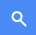
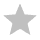
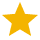
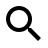
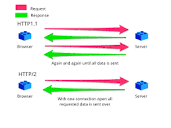
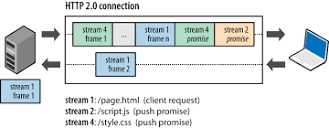
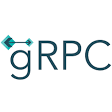
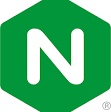
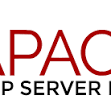

In [31]:
decompressed = gzip.decompress(body)
decompressed


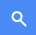
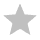
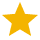
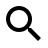
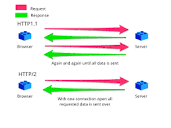
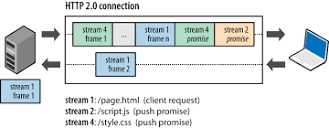
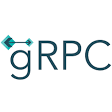
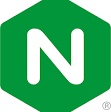
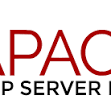

In [32]:
import re
from IPython.core.display import display, HTML
css_body_cleaner = re.compile(r'(<style>.*?)body\s*\{.+?\}(.*?</style>)')
display(HTML(re.sub(css_body_cleaner, r'\1\2', decompressed.decode("latin1"))))

In [33]:
https_conn.close()